##  Spiral plot  ##

[Spiral plot](http://cs.lnu.se/isovis/courses/spring07/dac751/papers/TimeSpiralsInfoVis2001.pdf) is a method of visualizing (periodic) time series. Here we adapt it to visualize tennis tournament results for Simona Halep, No 2 WTA 2015 ranking.

We generate bar charts of set results in each tournament along an Archimedean spiral of equation
$z(\theta)=a\theta e^{-i \theta}$, $a>0, \theta>3\pi/2$. Our bars are curvilinear bars, i.e. they have spiral arcs as base.

Matplotlib plot of this spiral:

In [2]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
PI=np.pi

(-60.0, 60.0, -50.0, 50.0)

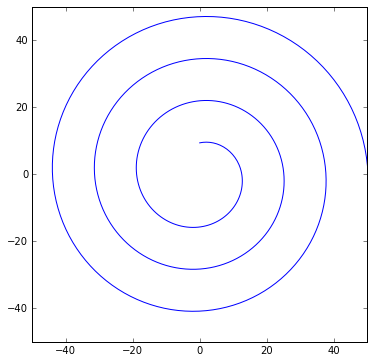

In [4]:
a=2
theta=np.linspace(3*PI/2, 8*PI, 400)
z=a*theta*np.exp(-1j*theta)
plt.figure(figsize=(6,6))
plt.plot(z.real, z.imag)
plt.axis('equal')


Each ray (starting from origin O(0,0)) crosses successive turnings  of the spiral at constant distance points, namely at distance=$2\pi a$.
With our choice a=2, this distance is $4\pi=12.56637$. Hence we set the tallest bar corresponding to 
a set score of 7 as having the height 10. The bar height corresponding to any set score in  $\{0, 1, 2, \ldots, 7\}$  can be read from  the following dictionary:

In [5]:
h=7.0
score={0: 0., 1:10./h, 2: 20/h, 3: 30/h, 4: 40/h, 5: 50/h, 6: 60/h, 7: 70/h}
score[6]

8.571428571428571

In [6]:
import plotly.plotly as py
from plotly.graph_objs import *

Read the json file created from data posted at [wtatennis.com](http://www.wtatennis.com/players/player/13516/title/simona-halep):

In [7]:
import json
with open("halep2015.json") as json_file:
    jdata = json.load(json_file)
print jdata['Shenzen']

[{u'rank': 3}, {u'points': 280}, {u'prize': 111163}, {u'A Beck (55)': [4, 6, 6, 4, 6, 3]}, {u'N Vikhlyantseva (584)': [6, 2, 6, 2]}, {u'A Krunic (84)': [6, 3, 6, 3]}, {u'S Zheng (97)': [6, 2, 6, 3]}, {u'T Bacsinszky (67)': [6, 2, 6, 2]}]


`played_at` is the list of tournaments Simona Halep participated in:

In [8]:
played_at=['Shenzen', 'Australian Open', 'Fed Cup', 'Dubai', 'Indiana Wells', 'Miami',
          'Stuttgart', 'Madrid', 'Rome', 'French Open', 'Birmingham', 'Wimbledon', 'Toronto',
          'Cincinnati', 'US Open', 'Guangzhou',  'Wuhan', 'Beijing', 'WTA Finals' ]

In [9]:
#define a dict giving the number of matches played by Halep in  each tournament k
nmatches={ k: len(jdata[where][3:]) for  (k, where) in enumerate(played_at) }              

The arcs of spiral are defined as Plotly SVG paths:

In [11]:
def make_arc(aa, theta0, theta1, dist, nr=4):# defines the arc of spiral between theta0 and theta1, 
    
        theta=np.linspace(theta0, theta1, nr)
        pts=(aa*theta+dist)*np.exp(-1j*theta)# points on spiral arc r=aa*theta
    
        string_arc='M '
        for k in range(len(theta)):
            string_arc+=str(pts.real[k])+', '+str(pts.imag[k])+' L '
        return   string_arc

In [12]:
make_arc(0.2, PI+0.2, PI, 4)[1:]

' -4.57526296667, 0.927451718436 L -4.61366881509, 0.618827320468 L -4.63134090185, 0.309214291159 L -4.62831853072, -5.66805547408e-16 L '

The function `make_bar` returns a Plotly dict that will be used to generate the bar shapes:

In [13]:
def make_bar(bar_height, theta0, fill_color, rad=0.2, a=2):
    theta1=theta0+rad
    C=(a*theta1+bar_height)*np.exp(-1j*theta1)
    D=a*theta0*np.exp(-1j*theta0)
    
    return dict(               
            line=Line(color=fill_color, width=0.5
                     ), 
            path= make_arc(a, theta0, theta0+rad, 0.0)+str(C.real)+', '+str(C.imag)+' '+\
                  make_arc(a, theta1, theta0, bar_height)[1:]+ str(D.real)+', '+str(D.imag),
            type='path',
            fillcolor=fill_color    
        )   
    

Define a function setting the plot layout:

In [14]:
def make_layout(title, plot_size):
    axis=dict(showline=False, # hide axis line, grid, ticklabels and  title
          zeroline=False,
          showgrid=False,
          showticklabels=False,
          title='' 
          )

    return Layout(title=title,
                  font=Font(size=12), 
                  xaxis=XAxis(axis),
                  yaxis=YAxis(axis),
                  showlegend=False,
                  width=plot_size,
                  height=plot_size,
                  margin=Margin(t=30, b=30, l=30, r=30),
                  hovermode='closest',
                  shapes=[]# below we append to shapes the dicts defining 
                           #the bars associated to set scores
                           
                 )  

In [15]:
title='Simona Halep 2015 Tournament Results<br>Each arc of spiral corresponds to a tournament'

In [16]:
layout=make_layout(title, 700)

The bar charts corresponding to two consecutive matches in a tournament are separated by an arc of length `interM`,
whereas the bar charts corresponding to two consecutive tournaments are separated by a longer arc, `interT`:

In [17]:
interM=2.0#the length of circle arc approximating an arc of spiral, between two consecutive matches
interT=3.5# between two tournaments

The bars are colored by the following rule: the bars associated to Halep's results are colored in red (`colors[0]`),
while the colors for opponents are chosen according to their rank (see the code below). The darker colors correspond to high ranked opponents, while the lighter ones to lower ranked opponents.

In [18]:
colors=['#dc3148','#864d7f','#9e70a2', '#caaac2','#d6c7dd', '#e6e1dd'] 

Get data for generating bars and data  to be displayed when hovering the mouse over the plot:

In [19]:
a=2.0 # the parameter in spiral equation z(theta)=a*theta exp(-i theta)
theta0=3*PI/2 # the starting point of the spiral
Theta=[]# the list of tournament arc ends
Opponent=[]# the list of opponents in each set of all matches played by halep
rankOp=[]# rank of opponent list
middleBar=[]# theta coordinate for the middle point of each bar base
half_h=[]# the list of  bar heights/2
wb=1.5# bar width along the spiral
rad=wb/(a*theta0)#the  angle in radians corresponding to an arc of length wb, 
                 #within the circle of radius a*theta
rank_Halep=[]
Halep_set_sc=[]# list of Halep set scores
Opponent_set_sc=[]# list of opponent set scores
bar_colors=[]# the list of colors assigned to each bar in bar charts

for k, where in enumerate(played_at):
    nr=nmatches[k]# nr is the number of matches played by Halep in the k^th tournament
    Theta.append(theta0)
    for match in range(nr):
        player=jdata[where][3+match].keys()[0]# opponent name in match match
       
        rankOp.append(int(player.partition('(')[2].partition(')')[0]))#Extract opponent rank:
        set_sc=jdata[where][3+match].values()[0]#set scores in match match
        sets=len(set_sc)
        #set bar colors according to opponent rank
        if rankOp[-1] in range(1,11): col=colors[1]
        elif rankOp[-1] in range(11, 21): col=colors[2] 
        elif rankOp[-1] in range(21, 51): col=colors[3] 
        elif rankOp[-1] in range(51, 101): col=colors[4]  
        else: col=colors[5] 
            
            
        for s  in range(0, sets, 2):
            middleBar.append(0.5*(2*theta0+rad))#  get the middle of each angular interval 
                                                # defining bar base
            rank_Halep+=[jdata[where][0]['rank']]
            Halep_set_sc.append(set_sc[s])
      
            half_h.append(0.5*score[set_sc[s]])# middle of bar height
            bar_colors.append(colors[0])
            
            layout['shapes'].append(make_bar(score[set_sc[s]], theta0, colors[0], rad=rad, a=2))
            rad=wb/(a*theta0)
            
            theta0=theta0+rad
            middleBar.append(0.5*(2*theta0+rad))
            Opponent_set_sc.append(set_sc[s+1])
            half_h.append(0.5*score[set_sc[s+1]])
            Opponent.append(jdata[where][3+match].keys()[0])
            bar_colors.append(col)
            
            layout['shapes'].append(make_bar(score[set_sc[s+1]], theta0, col , rad=rad, a=2))
            
            rad=wb/(a*theta0)
            theta0=theta0+rad
        gapM=interM/(a*theta0)    
        theta0=theta0-rad+gapM
    gapT=interT/(a*theta0) 
    Theta.append(theta0)
    theta0=theta0-gapM+gapT   
    

Check list lengths:

In [20]:
print len(bar_colors), len(middleBar), len(Opponent), len(half_h)

308 308 154 308


Define the list of strings to be displayed for each bar:

In [21]:
nrB=nrB=len(bar_colors)
playersRank=['n']*nrB

for k in range(0,nrB, 2):
    playersRank[k]=u'Halep'+' ('+'{:d}'.format(rank_Halep[k/2])+')'+'<br>'+\
                   'set score: '+str(Halep_set_sc[k/2])
for k in range(1, nrB, 2):
    playersRank[k]=Opponent[(k-1)/2]+'<br>'+'set score: '+str(Opponent_set_sc[(k-1)/2])

In [22]:
players=[]# Plotly traces that define position of text on bars

for k in range(nrB):
    z=(a*middleBar[k]+half_h[k])*np.exp(-1j*middleBar[k])
    players.append(Scatter(x=[z.real],
                           y=[z.imag],
                           mode='markers',
                           marker=Marker(size=0.25, color=bar_colors[k]),
                           name='',
                           text=playersRank[k],
                           hoverinfo='text'
                          )
                  )

In [23]:
LT=len(Theta)
aa=[a-0.11]*2+[a-0.1]*3+[a-0.085]*5+[a-0.075]*5+[a-0.065]*4# here is a trick to get  spiral arcs 
#looking at the same distance from the bar charts

spiral=[] #Plotly traces of spiral arcs
for k in range(0, LT, 2):
    X=[]
    Y=[]
    theta=np.linspace(Theta[k], Theta[k+1], 40)
    Z=aa[k/2]*theta*np.exp(-1j*theta)
    X+=Z.real.tolist()
    Y+=Z.imag.tolist()
    X.append(None)
    Y.append(None)
    spiral.append(Scatter(x=X,
                          y=Y,
                          mode='lines',
                          line=Line(color='#23238E', width=4),
                          name='',
                          text=played_at[k/2],
                          hoverinfo='text'))

In [24]:
data=Data(spiral+players)
fig=Figure(data=data,layout=layout)

In [25]:
py.sign_in('empet', 'my_api_key')
py.iplot(fig, filename='spiral-plot')

In [64]:
from IPython.core.display import HTML
def  css_styling():
    styles = open("./custom.css", "r").read()
    return HTML(styles)
css_styling()